# Prep


In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

os.chdir("/content/drive/My Drive/Case Studies in ML")

Mounted at /content/drive


In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from scipy.fft import fft
from sklearn.preprocessing import MinMaxScaler

In [3]:
!pip install skforecast
!pip install feature-engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.0/375.0 kB 5.0 MB/s eta 0:00:00


In [4]:
# Data manipulation
# ==============================================================================
import warnings
import shap
from skforecast.preprocessing import RollingFeatures
from skforecast.model_selection import TimeSeriesFold
from skforecast.feature_selection import select_features
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.direct import ForecasterDirect
from skforecast.recursive import ForecasterRecursive
from skforecast.recursive import ForecasterEquivalentDate
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import PolynomialFeatures
from lightgbm import LGBMRegressor
import sklearn
import lightgbm
import skforecast
import numpy as np
import pandas as pd
# from astral.sun import sun
# from astral import LocationInfo
from skforecast.datasets import fetch_dataset
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from feature_engine.timeseries.forecasting import WindowFeatures

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from skforecast.plot import plot_residuals
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size': 8})

# Modelling and Forecasting
# ==============================================================================

# Warnings configuration
# ==============================================================================
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version lightgbm: {lightgbm.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.




Version skforecast: 0.14.0
Version scikit-learn: 1.5.2
Version lightgbm: 4.5.0
Version pandas: 2.2.2
Version numpy: 1.26.4


# Preprocessing


In [109]:
df = pd.read_csv("electricityConsumptionAndProductioction.csv")
df.head()

,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


In [110]:
def create_time_features(df, datetime_col):
    # Convert the datetime column to datetime format if not already in that format
    df[datetime_col] = pd.to_datetime(
        df[datetime_col], format="%Y-%m-%d %H:%M:%S")
    df.set_index(datetime_col, inplace=True)
    df = df.loc[~df.index.duplicated(keep='first')]
    df = df.asfreq('h')
    df.fillna(method='ffill', inplace=True)

    # Create new columns for various time features
    features_to_extract = [
        'month',
        'week',
        'day_of_week',
        'hour'
    ]

    calendar_transformer = DatetimeFeatures(
        variables='index',
        features_to_extract=features_to_extract,
        drop_original=True,
    )
    calendar_features = calendar_transformer.fit_transform(df)[
        features_to_extract]
    exogenous_features = calendar_features.copy()

    features_to_encode = [
        "month",
        "week",
        "day_of_week",
        "hour",
    ]
    max_values = {
        "month": 12,
        "week": 52,
        "day_of_week": 6,
        "hour": 23,
    }

    cyclical_encoder = CyclicalFeatures(
        variables=features_to_encode,
        max_values=max_values,
        drop_original=True
    )

    exogenous_features = cyclical_encoder.fit_transform(exogenous_features)

    df = df.merge(
        exogenous_features[exog_features],
        left_index=True,
        right_index=True,
        how='inner'  # Use only dates for which we have all the variables
    )

    return df


df.loc[df['Wind'] < 0, 'Wind'] = 0
df = create_time_features(df, 'DateTime')
additive_decomposition = seasonal_decompose(
    x=df['Consumption'], model='additive', period=24)
df['Trend'] = additive_decomposition.trend
df['Seasonal'] = additive_decomposition.seasonal
df['Residual'] = additive_decomposition.resid

df.dropna(inplace=True)
df.head(2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-110-19faa71d255f>:7: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass,month_sin,month_cos,week_sin,week_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos,Trend,Seasonal,Residual
DateTime,,,,,,,,,,,,,,,,,,,,
2019-01-01 12:00:00,5776.0,5816.0,1390.0,0.0,1416.0,1423.0,1357.0,206.0,34.0,0.5,0.866025,0.120537,0.992709,0.866025,0.5,-0.136167,-0.990686,5942.979167,419.523094,-586.502260
2019-01-01 13:00:00,5744.0,5823.0,1389.0,15.0,1308.0,1412.0,1461.0,202.0,34.0,0.5,0.866025,0.120537,0.992709,0.866025,0.5,-0.398401,-0.917211,5915.458333,429.319218,-600.777552


Text(0.5, 1.0, 'Time of day Sine and Cosine')

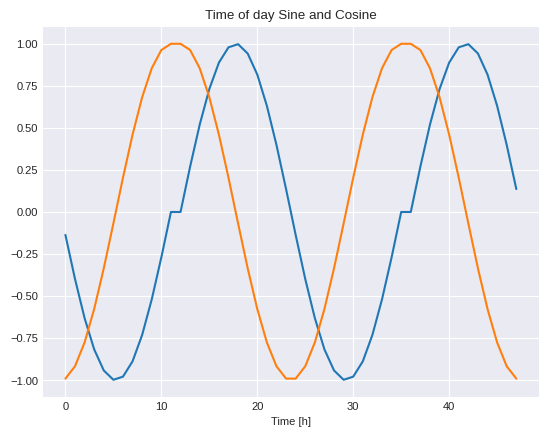

In [119]:
plt.plot(np.array(df['hour_sin'])[:48])
plt.plot(np.array(df['hour_cos'])[:48])
plt.xlabel('Time [h]')
plt.title('Time of day Sine and Cosine')

In [112]:
# Missing values
# ==============================================================================
print(f'Number of rows with missing values: {df.isnull().any(axis=1).sum()}')

Number of rows with missing values: 0


# Investigation


<ipython-input-11-568820bad373>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('viridis', len(column_means))(np.arange(len(column_means)))


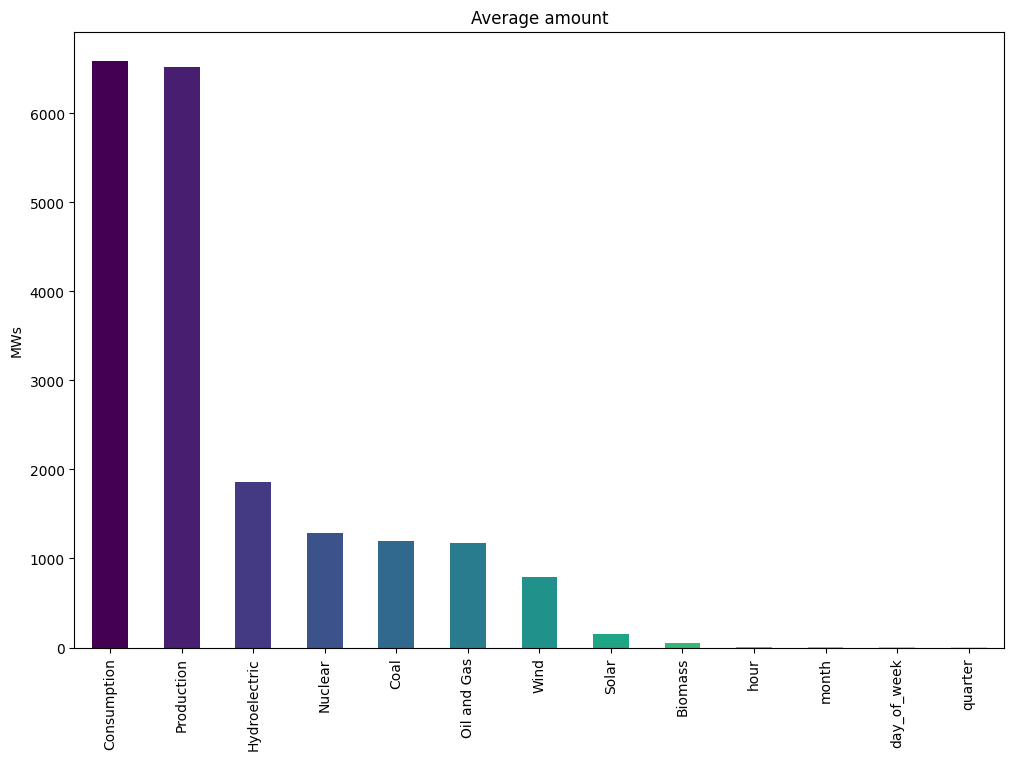

In [ ]:
import matplotlib.cm as cm
column_means = df.mean()
column_means.name = 'mean'
colors = cm.get_cmap('viridis', len(column_means))(
    np.arange(len(column_means)))
plt.figure(figsize=(12, 8))
column_means.sort_values(ascending=False).plot(
    kind='bar', title='Average amount', color=colors)
plt.ylabel('MWs')
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 5), sharex=False, sharey=True)
axs = axs.ravel()

# Demand distribution by month
df['month'] = df.index.month
df.boxplot(column='Consumption', by='month',
           ax=axs[0], flierprops={'markersize': 3, 'alpha': 0.3})
df.groupby('month')['Consumption'].median().plot(
    style='o-', linewidth=0.8, ax=axs[0])
axs[0].set_ylabel('Consumption')
axs[0].set_title('Consumption distribution by month', fontsize=9)

# Demand distribution by week day
df['week_day'] = df.index.day_of_week + 1
df.boxplot(column='Consumption', by='week_day',
           ax=axs[1], flierprops={'markersize': 3, 'alpha': 0.3})
df.groupby('week_day')['Consumption'].median().plot(
    style='o-', linewidth=0.8, ax=axs[1])
axs[1].set_ylabel('Consumption')
axs[1].set_title('Consumption distribution by week day', fontsize=9)

# Demand distribution by the hour of the day
df['hour_day'] = df.index.hour + 1
df.boxplot(column='Consumption', by='hour_day',
           ax=axs[2], flierprops={'markersize': 3, 'alpha': 0.3})
df.groupby('hour_day')['Consumption'].median().plot(
    style='o-', linewidth=0.8, ax=axs[2])
axs[2].set_ylabel('Consumption')
axs[2].set_title('Consumption distribution by the hour of the day', fontsize=9)

# Demand distribution by week day and hour of the day
mean_day_hour = df.groupby(["week_day", "hour_day"])["Consumption"].mean()
mean_day_hour.plot(ax=axs[3])
axs[3].set(
    title="Mean Consumption during week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel="Day and hour",
    ylabel="Number of Consumption"
)
axs[3].title.set_size(10)

df.drop(['month', 'week_day', 'hour_day'], inplace=True, axis=1)

fig.suptitle("Seasonality plots", fontsize=12)
fig.tight_layout()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Generate some data
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Plot on each subplot
for i, ax in enumerate(axes.flat):
    ax.plot(x, y * (i + 1))
    ax.set_title(f"Plot {i + 1}")
    ax.set_xlabel("X-axis")

# Add a common ylabel
fig.text(0.04, 0.5, 'Common Y-axis Label',
         va='center', rotation='vertical', fontsize=14)

# Adjust layout to prevent overlap
# Leave space for the ylabel on the left
plt.tight_layout(rect=[0.05, 0, 1, 1])

plt.show()

KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12))
groupby_cols = {'hour': list(range(0, 24)), 'day_of_week': ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], 'month': [
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']}
colors = ['red', 'green', 'blue']

for i, col in enumerate(groupby_cols):
    df.groupby(col)['Consumption'].mean().plot(
        ax=axes[i], color=colors[i], linewidth=2, marker='o')

    if col == 'month':
        axes[i].set_xticks(
            range(1, len(groupby_cols[col]) + 1), groupby_cols[col])
    else:
        axes[i].set_xticks(range(len(groupby_cols[col])), groupby_cols[col])

fig.text(0.04, 0.5, 'Average Consumption (MW)',
         rotation='vertical', fontsize=14)
plt.tight_layout(rect=[0.05, 0, 1, 1])
plt.show()

In [ ]:
plt.figure(figsize=(14, 8))

columns_map = {i: column for i, column in enumerate(df.columns)}

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i in range(3):
    for j in range(3):
        ax = axes[i, j]  # Access each subplot (axes is a 2D array)
        index = 3*i+j
        ax.hist(df[columns_map[index]], bins=50, alpha=0.5, label=columns_map[index],
                color=colors[index])  # Vary the data for each subplot
        ax.set_title(f"{columns_map[index]}")

plt.grid(True)
plt.show()

In [ ]:
df.describe()

In [ ]:
corr_matrix = df[['Consumption', 'Production', 'Nuclear', 'Wind',
                  'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
def get_sample_df(cols, start, end):
    return df[cols][start:end]


sample_df = get_sample_df(
    ['Consumption'], start="2019-01-01", end="2019-01-15")

In [ ]:
def seasonality(df, start="2019-01-01", end="2019-01-15", hours_diff=24):
    diff_df = df.diff(hours_diff)[start:end]
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
    df[start:end].plot(ax=axs[0], legend=False, marker=".")
    df[start:end].shift(24).plot(ax=axs[0], grid=True,
                                 legend=False, linestyle=":")
    diff_df.plot(ax=axs[1], grid=True, marker=".")
    plt.show()


seasonality(sample_df)

In [ ]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(12, 6))

autocorrelation_plot(sample_df)
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(12, 8))

fig, axes = plt.subplots(4, 1, figsize=(12, 12))

plot_acf(df['Consumption'], ax=axes[0], lags=100,
         title='Autocorrelation Function for Hourly data')
plot_acf(df['Consumption'].resample('D').mean(), ax=axes[1],
         lags=30, title='Autocorrelation Function for Daily data')
plot_acf(df['Consumption'].resample('W').mean(), ax=axes[2],
         lags=30, title='Autocorrelation Function for Weekly data')
plot_acf(df['Consumption'].resample('M').mean(), ax=axes[3],
         lags=30, title='Autocorrelation Function for Monthly data')

plt.subplots_adjust(top=1.1)

plt.show()

In [ ]:
24 * 7

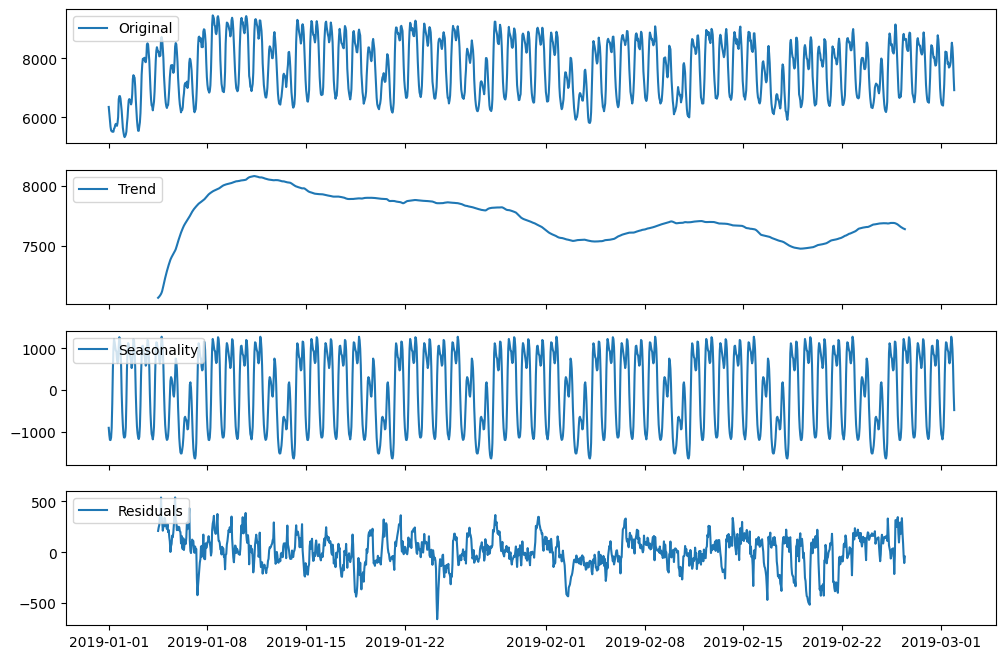

In [ ]:
additive_decomposition = seasonal_decompose(
    x=df['Consumption']['2019-01-01':'2019-03-01'], model='additive', period=24*7)


def seas_decomp_plots(original, decomposition):
    _, axes = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(12, 8))
    axes[0].plot(original, label='Original')
    axes[0].legend(loc='upper left')
    axes[1].plot(decomposition.trend, label='Trend')
    axes[1].legend(loc='upper left')
    axes[2].plot(decomposition.seasonal, label='Seasonality')
    axes[2].legend(loc='upper left')
    axes[3].plot(decomposition.resid, label='Residuals')
    axes[3].legend(loc='upper left')
    plt.show()


seas_decomp_plots(
    df['Consumption']['2019-01-01':'2019-03-01'], additive_decomposition)

In [ ]:
def fft_analysis(signal):

    # Linear detrending
    slope, intercept = np.polyfit(np.arange(len(signal)), signal, 1)
    trend = np.arange(len(signal)) * slope + intercept
    detrended = signal - trend

    fft_values = fft(detrended)
    frequencies = np.fft.fftfreq(len(fft_values))

    # Remove negative frequencies and sort
    positive_frequencies = frequencies[frequencies > 0]
    magnitudes = np.abs(fft_values)[frequencies > 0]

    # Identify dominant frequency
    dominant_frequency = positive_frequencies[np.argmax(magnitudes)]
    print(f"Dominant Frequency: {dominant_frequency:.3f}")

    # Convert frequency to period (e.g., days, weeks, months, etc.)
    dominant_period = 1 / dominant_frequency
    print(f"Dominant Period: {dominant_period:.2f} time units")

    return dominant_period, positive_frequencies, magnitudes


period, freqs, magnitudes = fft_analysis(sample_df['Consumption'].to_numpy())

In [ ]:
# Plotting the spectrum
plt.figure(figsize=(10, 3))
plt.stem(freqs, magnitudes)
plt.title('Frequency Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

In [ ]:
df['Consumption'].hist(figsize=(12, 8))

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(
    df['Consumption'])

In [ ]:
print(f"ADF: {adf:.2f}")
print(f"p-value: {pvalue}")
print(f"nobs: {nobs}")
print(f"critical values: {critical_values}")

In [ ]:
additive_decomposition = seasonal_decompose(
    x=df['Consumption'], model='additive', period=24)

In [ ]:
def run_sequence_plot(x, y, title, xlabel="Time", ylabel="Values", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10, 3.5))
    ax.plot(x, y, 'k-')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(alpha=0.3)
    return ax

In [ ]:
adf_after, pvalue_after, _, _, _, _ = adfuller(
    additive_decomposition.resid[12:-12])
print(f"ADF: {adf_after:.2f}")
print(f"p-value: {pvalue_after:.3f}")

In [ ]:
additive_decomposition.resid[12:-12].hist(figsize=(12, 8))

In [ ]:
run_sequence_plot(date_time, df['Consumption'],
                  title="Heteroskedastic time series???")

In [ ]:
adf_after, pvalue_after, _, _, _, _ = adfuller(df['Consumption'])
print(f"ADF: {adf_after:.2f}")
print(f"p-value: {pvalue_after:.3f}")

In [ ]:
adf_after, pvalue_after, _, _, _, _ = adfuller(
    df['Consumption'].diff(24)['2019-01-02':])
print(f"ADF: {adf_after:.2f}")
print(f"p-value: {pvalue_after:.3f}")

In [ ]:
run_sequence_plot(
    date_time[:-24], df['Consumption'].diff(24)['2019-01-02':], title='Diff')

In [ ]:
df['Consumption'].diff(24)['2019-01-02':].hist(figsize=(12, 8))

In [ ]:
import numpy as np
from scipy.stats import mstats

# Example data (normally distributed)
data = np.random.normal(loc=0, scale=1, size=1000)

# Perform normality test
statistic, p_value = mstats.normaltest(additive_decomposition.resid[12:-12])

# Output the results
print(f"Test Statistic: {statistic}")
print(f"P-value: {p_value}")

# Interpreting the result
if p_value < 0.05:
    print("The data does not follow a normal distribution (reject null hypothesis).")
else:
    print("The data follows a normal distribution (fail to reject null hypothesis).")

In [ ]:
import scipy.stats as stats

# Create a Q-Q plot
plt.figure(figsize=(8, 6))
stats.probplot(df['Consumption'], dist="norm", plot=plt)
plt.title('Q-Q Plot for Normal Distribution')
plt.show()

In [ ]:
import scipy.stats as stats

# Create a Q-Q plot
plt.figure(figsize=(8, 6))
stats.probplot(df['Consumption'].diff(
    24)['2019-01-02':], dist="norm", plot=plt)
plt.title('Q-Q Plot for Normal Distribution')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
stats.probplot(additive_decomposition.resid[12:-12], dist="norm", plot=plt)
plt.title('Q-Q Plot for Normal Distribution')
plt.show()

In [ ]:
additive_decomposition.resid.dropna().hist(figsize=(12, 8))

In [ ]:
# diff = df['Consumption'].diff(24).dropna().to_numpy()

In [ ]:
# df = df['2019-01-02 00:00:00':'2024-03-31 23:00:00']
# df['consumption_difference'] = diff

# df.head()

In [ ]:
480 / 24

In [ ]:
df_daily = df.resample('D').mean()
rolling_average_30_days = df_daily.rolling(window=30).mean()

fig, axes = plt.subplots(2, 1, figsize=(15, 8))
df_daily[['Consumption', 'Production']].plot(ax=axes[0], marker=".")
rolling_average_30_days[['Consumption', 'Production']].plot(
    ax=axes[1], grid=True, legend=False)
plt.show()

In [ ]:
date_time = df.index

plot_cols = ['Consumption', 'Production', 'Nuclear', 'Wind',
             'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']
plot_features = df[plot_cols]
plot_features.index = date_time
plot_features.plot(subplots=True, figsize=(12, 12))

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True, figsize=(12, 12))
plt.show()

In [ ]:
df.describe().transpose()

In [ ]:
n, bins, _ = plt.hist(df['Nuclear'], bins=50)
plt.show()

# Create train, val, test df


In [113]:
n = len(df)

numerical_columns = ['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric',
                     'Oil and Gas', 'Coal', 'Solar', 'Biomass', 'Trend', 'Seasonal', 'Residual']


def create_train_val_test(df, cols):
    train_df = df[cols][0:int(n*0.7)]
    val_df = df[cols][int(n*0.7):int(n*0.9)]
    test_df = df[cols][int(n*0.9):]

    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std

    train_df = train_df.asfreq('h')
    val_df = val_df.asfreq('h')
    test_df = test_df.asfreq('h')

    return train_df, val_df, test_df


train_df, val_df, test_df = create_train_val_test(df, df.columns)

end_train = train_df.tail(1).index.strftime('%Y-%m-%d %H:%M:%S')[0]
end_validation = val_df.tail(1).index.strftime('%Y-%m-%d %H:%M:%S')[0]
start_test = test_df.head(1).index.strftime('%Y-%m-%d %H:%M:%S')[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-115-cea8caf1f5fe>:9: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



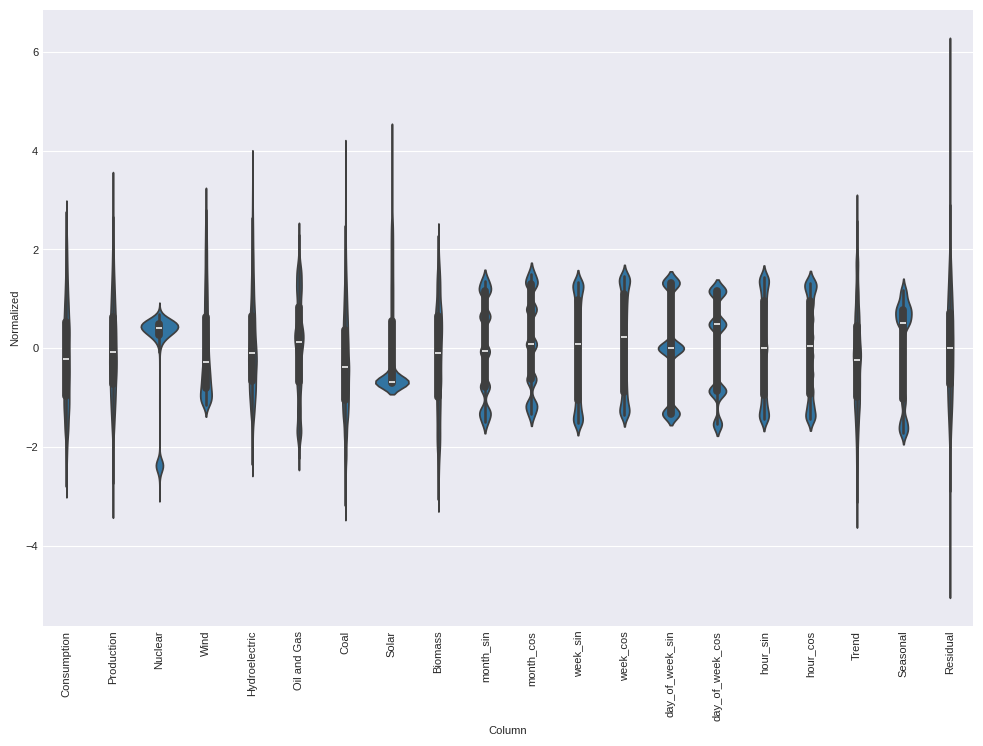

In [115]:
train_mean = df[0:int(n*0.7)].mean()
train_std = df[0:int(n*0.7)].std()

df_std = df
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 8))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.columns, rotation=90)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



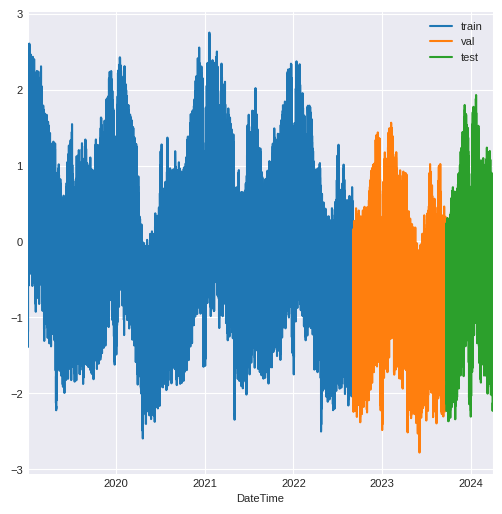

In [78]:
fig, ax = plt.subplots(figsize=(6, 6))
train_df['Consumption'].plot(ax=ax, label='train')
val_df['Consumption'].plot(ax=ax, label='val')
test_df['Consumption'].plot(ax=ax, label='test')
ax.legend()

# Windowing


In [121]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[
            self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[
            self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])


def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]

    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]]
                for name in self.label_columns],
            axis=-1
        )

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

    return inputs, labels


WindowGenerator.split_window = split_window


def plot(self, model=None, plot_col='Consumption', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')


WindowGenerator.plot = plot


def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds


WindowGenerator.make_dataset = make_dataset


@property
def train(self):
    return self.make_dataset(self.train_df)


@property
def val(self):
    return self.make_dataset(self.val_df)


@property
def test(self):
    return self.make_dataset(self.test_df)


@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result


def set_cols(self, cols=[]):
    self.train_df = self.train_df[cols]
    self.val_df = self.val_df[cols]
    self.test_df = self.test_df[cols]


WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.set_cols = set_cols

MAX_EPOCHS = 50


def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history


def plot_history(model_history, model, window):
    train_loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_loss, label='Training Loss', color='blue')
    plt.plot(epochs, val_loss, label='Validation Loss', color='orange')

    test_loss = model.evaluate(window.test, verbose=0)[0]

    plt.axhline(y=test_loss, color='green', linestyle='--',
                label=f'Test Loss: {test_loss:.4f}')

    plt.title('Training, Validation, and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def plot_performance(val_performance, performance):
    x = np.arange(len(performance))
    width = 0.3
    metric_name = 'mean_absolute_error'
    val_mae = [v[metric_name] for v in val_performance.values()]
    test_mae = [v[metric_name] for v in performance.values()]

    plt.ylabel('mean_absolute_error [Consumption, normalized]')
    plt.bar(x - 0.17, val_mae, width, label='Validation')
    plt.bar(x + 0.17, test_mae, width, label='Test')
    plt.xticks(ticks=x, labels=performance.keys(),
               rotation=45)
    _ = plt.legend()

# Single-step prediction


## Traditional Models


In [122]:
data = pd.concat([train_df, val_df, test_df])

data.head(1)

,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass,month_sin,month_cos,week_sin,week_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos,Trend,Seasonal,Residual
DateTime,,,,,,,,,,,,,,,,,,,,
2019-01-01 12:00:00,-0.957332,-0.71244,0.433396,-1.149731,-0.567293,0.627617,0.204273,0.211922,-1.797437,0.643659,1.30791,0.083508,1.445858,1.322342,0.483144,-0.196623,-1.432649,-1.149958,0.650085,-2.039419


In [123]:
forecaster = ForecasterDirect(
    regressor=LGBMRegressor(random_state=15926, verbose=-1),
    steps=24,
    lags=24,
)

# Lags used as predictors
lags_grid = [1, 12, 24]

# Regressor hyperparameters search space


def search_space(trial):
    search_space = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 500, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 5, step=1),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 0.3, step=0.1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 0.3, step=0.1),
        'lags': trial.suggest_categorical('lags', lags_grid)
    }
    return search_space


# Folds training and validation
cv = TimeSeriesFold(
    steps=24,
    initial_train_size=len(data[:end_train]),
    refit=False,
)

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster=forecaster,
    y=data.loc[:end_validation, 'Consumption'],
    exog=data.loc[:end_validation].drop('Consumption', axis=1),
    cv=cv,
    metric='mean_absolute_error',
    search_space=search_space,
    n_trials=3,  # Increase for more exhaustive search
    random_state=123,
    return_best=True,
    n_jobs='auto',
    verbose=False,
    show_progress=True
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/3 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1] 
  Parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05783962364576546, 'reg_alpha': 0.2, 'reg_lambda': 0.2}
  Backtesting metric: 0.06970030344934552


In [124]:
best_params = results_search.at[0, 'params']
best_params = best_params | {'random_state': 15926, 'verbose': -1}
best_lags = results_search.at[0, 'lags']

print(best_params)

results_search.head(3)

{'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05783962364576546, 'reg_alpha': 0.2, 'reg_lambda': 0.2, 'random_state': 15926, 'verbose': -1}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,lags,params,mean_absolute_error,n_estimators,max_depth,learning_rate,reg_alpha,reg_lambda
0,[1],"{'n_estimators': 300, 'max_depth': 3, 'learnin...",0.069700,300.0,3.0,0.057840,0.2,0.2
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 400, 'max_depth': 4, 'learnin...",0.070480,400.0,4.0,0.040886,0.2,0.1
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'n_estimators': 500, 'max_depth': 3, 'learnin...",0.074067,500.0,3.0,0.030417,0.2,0.2


In [125]:
forecaster

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



================ 
ForecasterDirect 
================ 
Regressor: LGBMRegressor 
Lags: [1] 
Window features: None 
Window size: 1 
Maximum steps to predict: 24 
Exogenous included: True 
Exogenous names: 
    Production, Nuclear, Wind, Hydroelectric, Oil and Gas, Coal, Solar, Biomass,
    month_sin, month_cos, week_sin, week_cos, day_of_week_sin, day_of_week_cos,
    hour_sin, hour_cos, Trend, Seasonal, Residual 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2019-01-01 12:00:00'), Timestamp('2023-09-21 20:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.05783962364576546,
    'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001,
    'min_split_gain': 0.0, 'n_estimators': 300, 'n_jobs': None, 'num_leaves':
    31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.2,
    'reg_lambda': 0.2, 'subsample': 1.0, 'subsample_for_bin': 200000,
    'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-11-24 12:38:35 
Last fit date: 2024-11-24 12:42:30 
Skforecast version: 0.14.0 
Python version: 3.10.12 
Forecaster id: None

In [126]:
cv = TimeSeriesFold(
    steps=24,
    initial_train_size=len(data[:end_validation]),
    refit=False,
)

metric, predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=data['Consumption'],
    exog=data.drop('Consumption', axis=1),
    cv=cv,
    metric='mean_absolute_error',
    n_jobs='auto',
    verbose=True,  # Change to True to see detailed information
    show_progress=True
)

Information of folds
--------------------
Number of observations used for initial training: 41385
Number of observations used for backtesting: 4599
    Number of folds: 192
    Number skipped folds: 0 
    Number of steps per fold: 24
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 15 observations.

Fold: 0
    Training:   2019-01-01 12:00:00 -- 2023-09-21 20:00:00  (n=41385)
    Validation: 2023-09-21 21:00:00 -- 2023-09-22 20:00:00  (n=24)
Fold: 1
    Training:   No training in this fold
    Validation: 2023-09-22 21:00:00 -- 2023-09-23 20:00:00  (n=24)
Fold: 2
    Training:   No training in this fold
    Validation: 2023-09-23 21:00:00 -- 2023-09-24 20:00:00  (n=24)
Fold: 3
    Training:   No training in this fold
    Validation: 2023-09-24 21:00:00 -- 2023-09-25 20:00:00  (n=24)
Fold: 4
    Training:   No training in this fold
    Validation: 2023-09-25 21:00:00 -- 2023-09-26 20:00:00  (n=24)
Fold: 5
    T

  0%|          | 0/192 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,mean_absolute_error
0,0.047226


                         pred
2023-09-21 21:00:00  0.017526
2023-09-21 22:00:00 -0.628620
2023-09-21 23:00:00 -1.099288
2023-09-22 00:00:00 -1.462997
2023-09-22 01:00:00 -1.569856
MAE:    mean_absolute_error
0             0.047226


<Axes: xlabel='DateTime'>

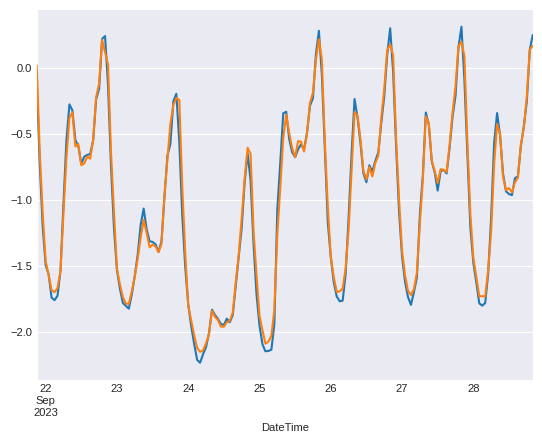

In [127]:
display(metric)
print(predictions.head())

print(f"MAE: {metric}")

test_df['Consumption'][:24*7].plot()
predictions['pred'][:24*7].plot()

In [179]:
importance = forecaster.get_feature_importances(step=1)
importance.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,feature,importance
0,lag_1,515
17,Trend,399
18,Seasonal,297
19,Residual,279
15,hour_sin,231
7,Solar,111
16,hour_cos,104
12,week_cos,61
10,month_cos,40
13,day_of_week_sin,27


## Neural Networks


In [128]:
def create_conv_window(conv_width, label_width, shift, label_columns):
    conv_window = WindowGenerator(
        input_width=conv_width,
        label_width=label_width,
        shift=shift,
        label_columns=label_columns)
    conv_window.set_cols(cols=train_df.columns)

    for example_inputs, example_labels in conv_window.train.take(1):
        print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
        print(f'Labels shape (batch, time, features): {example_labels.shape}')

    for col in label_columns:
        conv_window.plot(plot_col=col)
        plt.suptitle(
            f"Given {conv_width} hours of inputs, predict {label_width} hour into the future for column {col}.")

    return conv_window

In [129]:
val_performance = {}
performance = {}

Inputs shape (batch, time, features): (32, 24, 20)
Labels shape (batch, time, features): (32, 1, 1)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_4 (Reshape)                  │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0475 - mean_absolute_error: 0.2037 - val_loss: 0.0095 - val_mean_absolute_error: 0.1097
Epoch 2/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0058 - mean_absolute_error: 0.0833 - val_loss: 0.0066 - val_mean_absolute_error: 0.0900
Epoch 3/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0045 - mean_absolute_error: 0.0730 - val_loss: 0.0073 - val_mean_absolute_error: 0.0966
Epoch 4/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0040 - mean_absolute_error: 0.0683 - val_loss: 0.0070 - val_mean_absolute_error: 0.0948
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mean_absolute_error: 0.0953


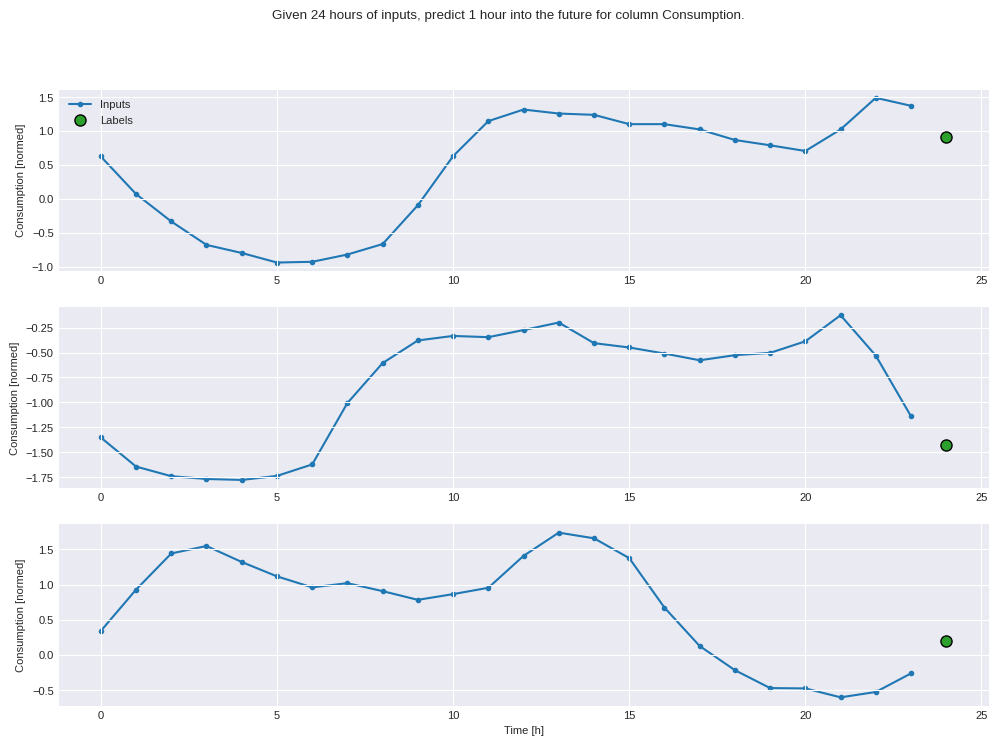

In [130]:
CONV_WIDTH = 24
conv_window = create_conv_window(
    conv_width=CONV_WIDTH, label_width=1, shift=1, label_columns=['Consumption'])

dense_model = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

print(dense_model.summary())

dense_history = compile_and_fit(dense_model, conv_window)

val_performance['Purely dense'] = dense_model.evaluate(
    conv_window.val, return_dict=True)
performance['Purely dense'] = dense_model.evaluate(
    conv_window.test, verbose=0, return_dict=True)

Conv window
Input shape: (32, 24, 20)
Labels shape: (32, 1, 1)
Output shape: (32, 1, 1)


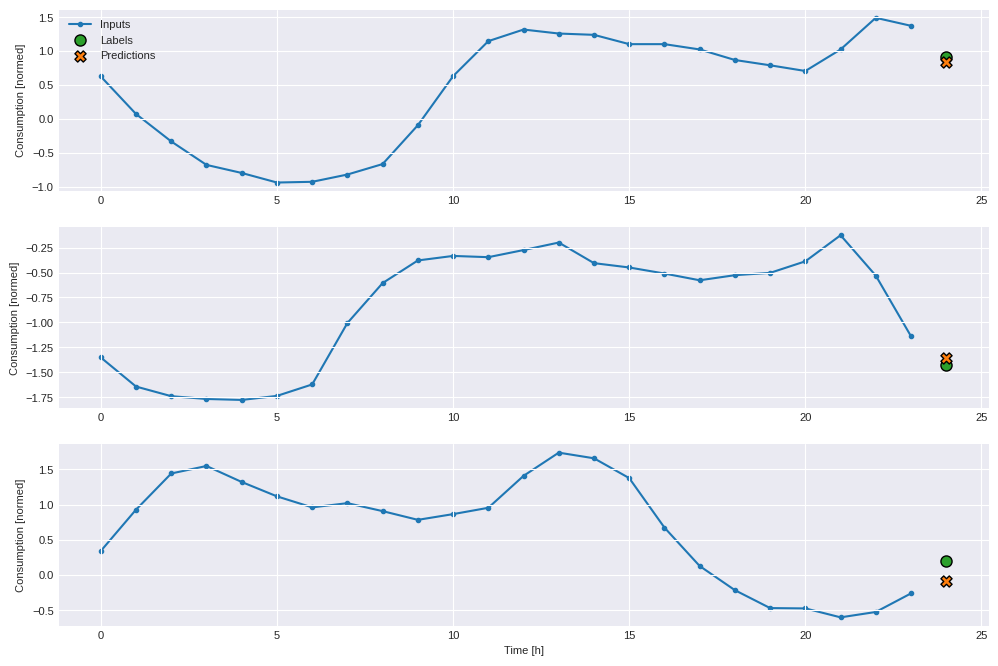

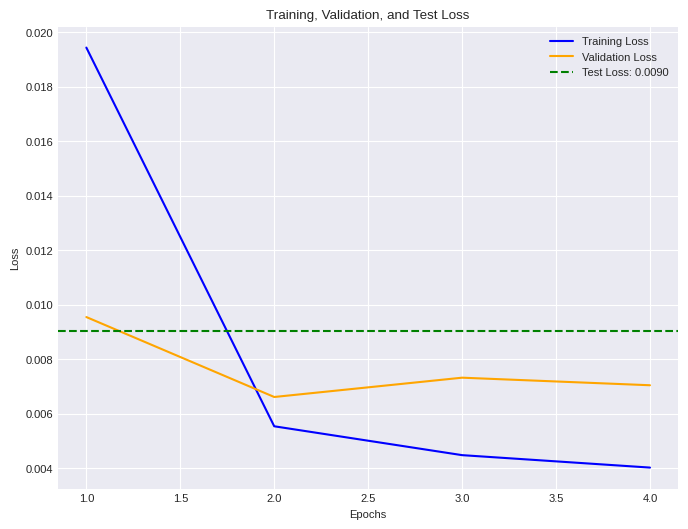

In [131]:
print("Conv window")
print('Input shape:', conv_window.example[0].shape)
print('Labels shape:', conv_window.example[1].shape)
print('Output shape:', dense_model(conv_window.example[0]).shape)

conv_window.plot(dense_model, plot_col='Consumption')
plot_history(dense_history, dense_model, conv_window)

Inputs shape (batch, time, features): (32, 24, 20)
Labels shape (batch, time, features): (32, 1, 1)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0329 - mean_absolute_error: 0.1649 - val_loss: 0.0073 - val_mean_absolute_error: 0.0952
Epoch 2/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0048 - mean_absolute_error: 0.0752 - val_loss: 0.0067 - val_mean_absolute_error: 0.0908
Epoch 3/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0042 - mean_absolute_error: 0.0702 - val_loss: 0.0071 - val_mean_absolute_error: 0.0939
Epoch 4/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0037 - mean_absolute_error: 0.0658 - val_loss: 0.0056 - val_mean_absolute_error: 0.0829
Epoch 5/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0035 - mean_absolute_error: 0.0639 - val_loss: 0.0047 - val_mean_absolute_error: 0.0757
Epoch 6/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0033 - mean_absolute_error: 0.0612 - val_loss: 0.0054 - val_mean_absolute_error: 0.0810
Epoch 7/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0032 - mean_abso

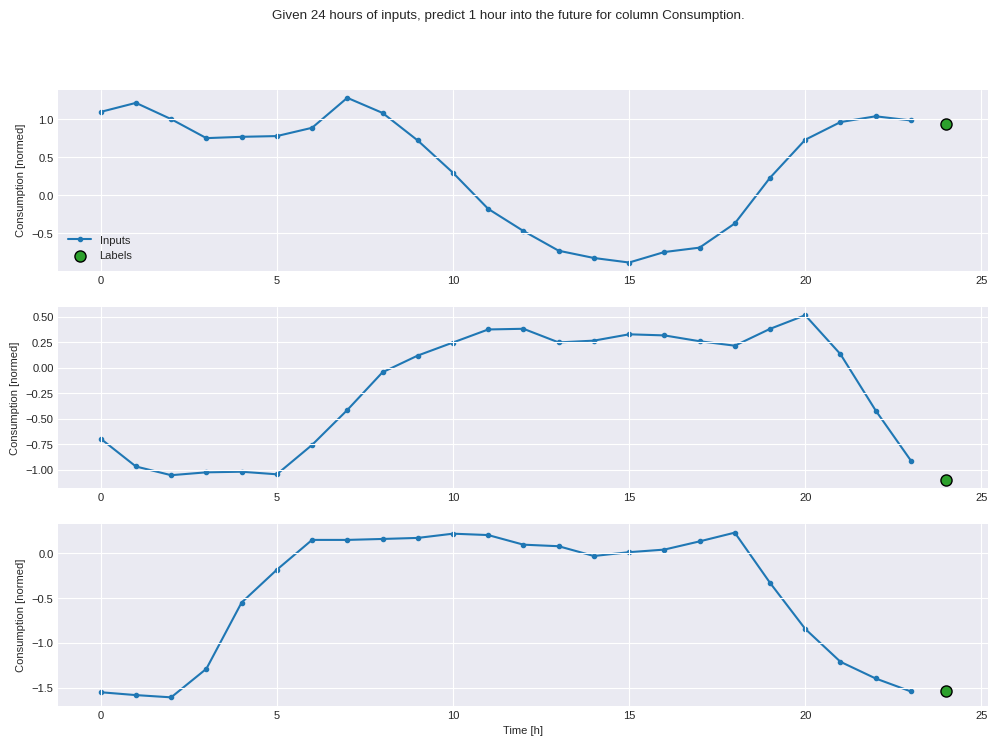

In [132]:
conv_window = create_conv_window(
    conv_width=CONV_WIDTH, label_width=1, shift=1, label_columns=['Consumption'])

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(units=1),
])

print(conv_model.summary())

conv_history = compile_and_fit(conv_model, conv_window)

val_performance['Conv'] = conv_model.evaluate(
    conv_window.val, return_dict=True)
performance['Conv'] = conv_model.evaluate(
    conv_window.test, verbose=0, return_dict=True)

Conv window
Input shape: (32, 24, 20)
Labels shape: (32, 1, 1)
Output shape: (32, 1, 1)


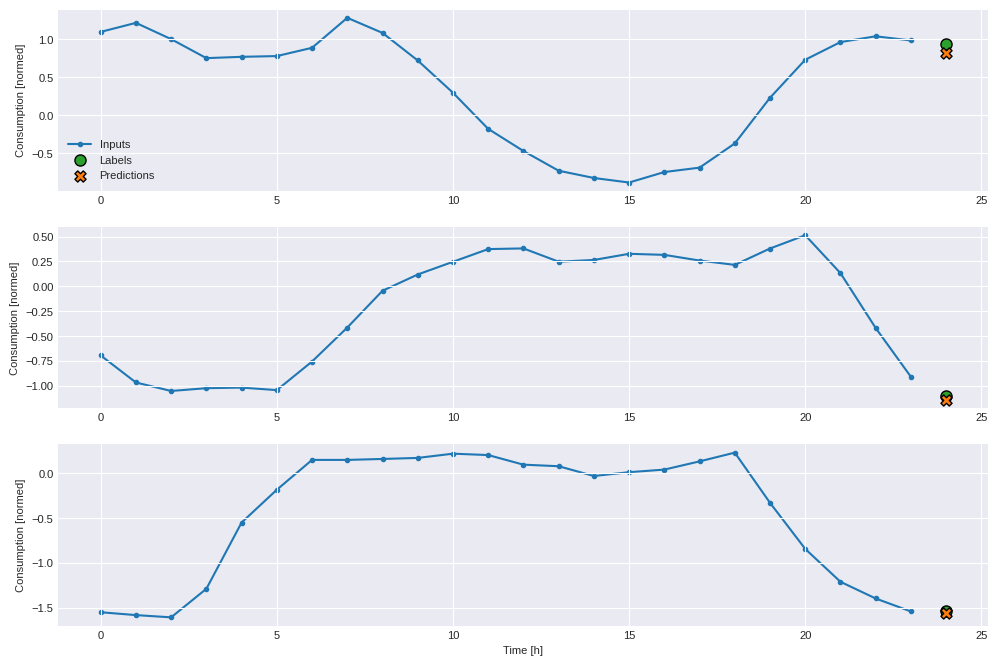

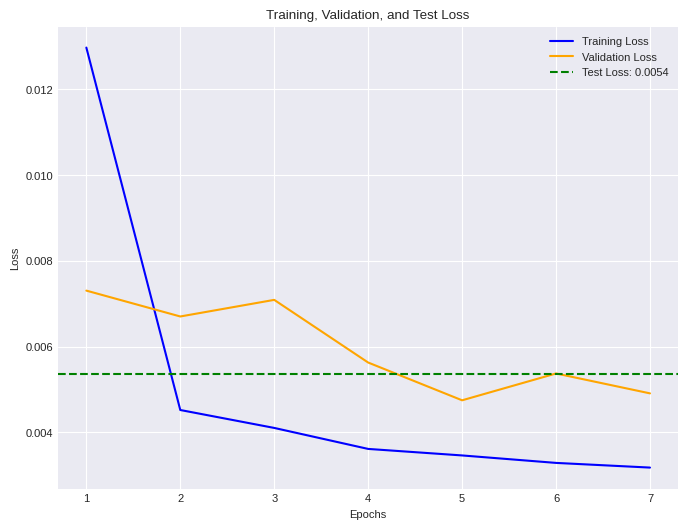

In [133]:
print("Conv window")
print('Input shape:', conv_window.example[0].shape)
print('Labels shape:', conv_window.example[1].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

conv_window.plot(conv_model, plot_col='Consumption')
plot_history(conv_history, conv_model, conv_window)

In [134]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1])
])

print(lstm_model.summary())

lstm_history = compile_and_fit(lstm_model, conv_window)

val_performance['LSTM'] = lstm_model.evaluate(
    conv_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(
    conv_window.test, verbose=0, return_dict=True)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_11 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_5 (Reshape)                  │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0467 - mean_absolute_error: 0.1878 - val_loss: 0.0070 - val_mean_absolute_error: 0.0919
Epoch 2/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0043 - mean_absolute_error: 0.0706 - val_loss: 0.0052 - val_mean_absolute_error: 0.0778
Epoch 3/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0037 - mean_absolute_error: 0.0654 - val_loss: 0.0051 - val_mean_absolute_error: 0.0763
Epoch 4/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0035 - mean_absolute_error: 0.0634 - val_loss: 0.0048 - val_mean_absolute_error: 0.0756
Epoch 5/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0034 - mean_absolute_error: 0.0625 - val_loss: 0.0041 - val_mean_absolute_error: 0.0698
Epoch 6/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0602 - val_loss: 0.0057 - val_mean_absolute_error: 0.0838
Epoch 7/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0031 - mean_abso

Conv window
Input shape: (32, 24, 20)
Labels shape: (32, 1, 1)
Output shape: (32, 1, 1)


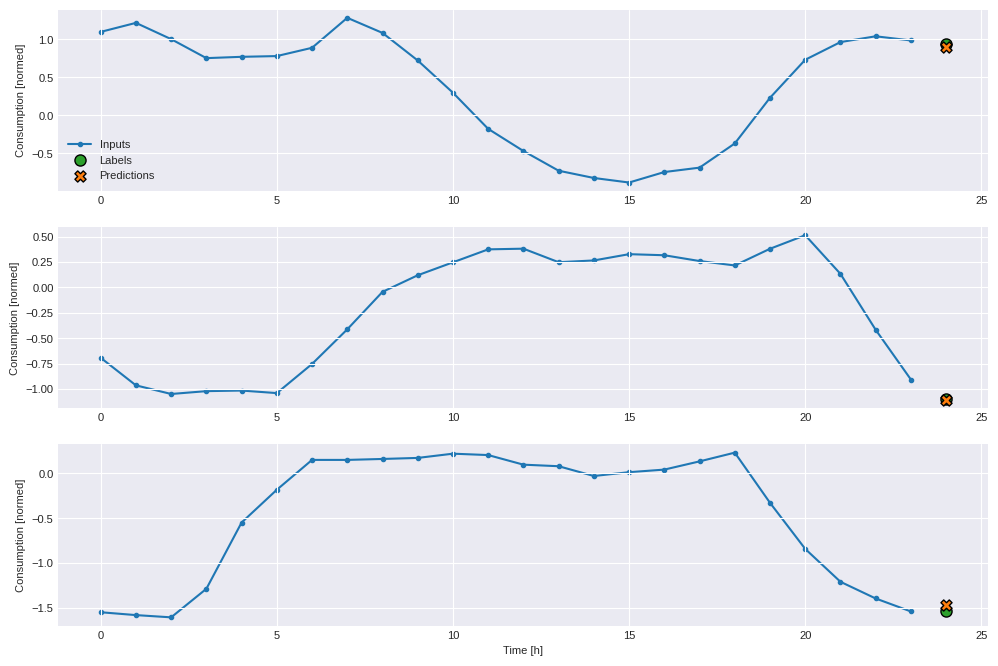

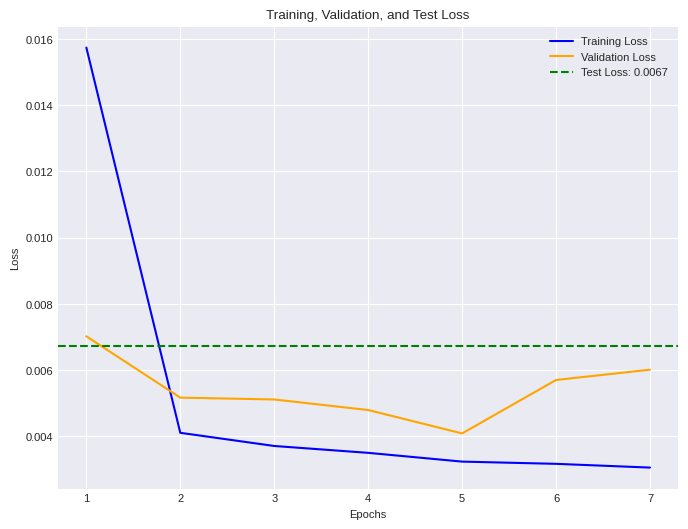

In [135]:
print("Conv window")
print('Input shape:', conv_window.example[0].shape)
print('Labels shape:', conv_window.example[1].shape)
print('Output shape:', lstm_model(conv_window.example[0]).shape)

conv_window.plot(lstm_model, plot_col='Consumption')
plot_history(lstm_history, lstm_model, conv_window)

Inputs shape (batch, time, features): (32, 24, 20)
Labels shape (batch, time, features): (32, 1, 1)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_87 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_88 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_89 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_90 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_91 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_92 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_93 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_94 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_20 (GRU)                         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_23 (Reshape)                 │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 37s 28ms/step - loss: 0.1106 - mean_absolute_error: 0.3307 - val_loss: 0.0203 - val_mean_absolute_error: 0.1557
Epoch 2/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - loss: 0.0101 - mean_absolute_error: 0.1076 - val_loss: 0.0176 - val_mean_absolute_error: 0.1502
Epoch 3/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - loss: 0.0074 - mean_absolute_error: 0.0923 - val_loss: 0.0094 - val_mean_absolute_error: 0.1044
Epoch 4/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - loss: 0.0056 - mean_absolute_error: 0.0802 - val_loss: 0.0092 - val_mean_absolute_error: 0.1043
Epoch 5/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 30s 29ms/step - loss: 0.0053 - mean_absolute_error: 0.0779 - val_loss: 0.0069 - val_mean_absolute_error: 0.0898
Epoch 6/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - loss: 0.0047 - mean_absolute_error: 0.0737 - val_loss: 0.0078 - val_mean_absolute_error: 0.0982
Epoch 7/50
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 38s 27ms/step - loss: 0.0046 

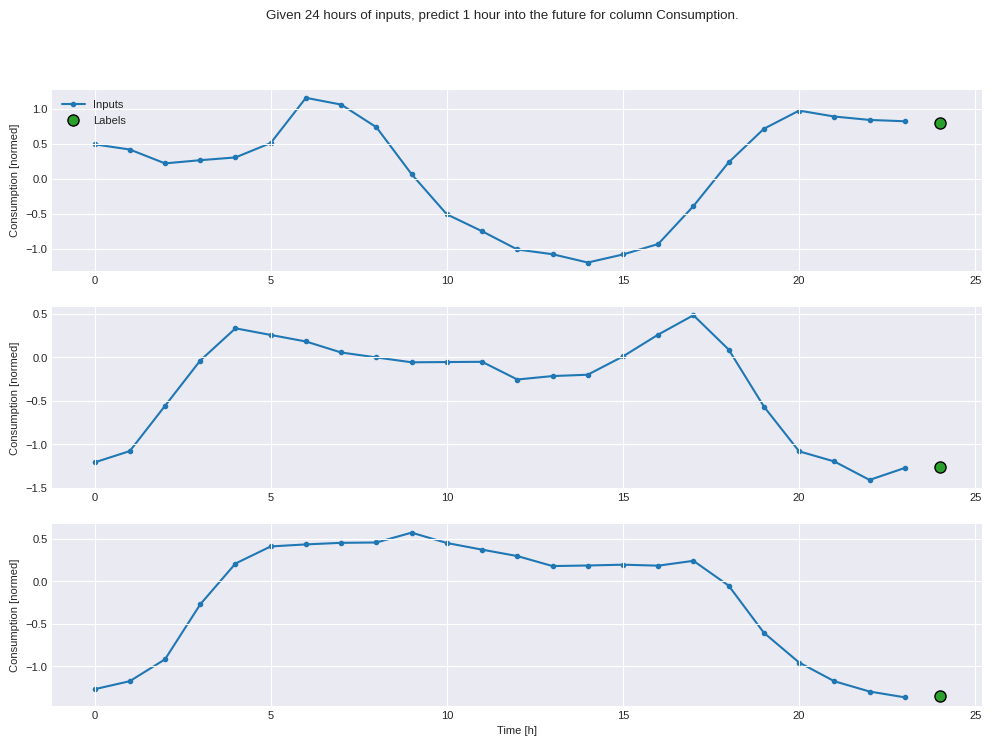

In [147]:
conv_window = create_conv_window(
    conv_width=24, label_width=1, shift=1, label_columns=['Consumption'])

wavenet_model = tf.keras.Sequential()
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=16, kernel_size=2, padding="causal", activation="relu",
        dilation_rate=rate))
# wavenet_model.add(tf.keras.layers.Conv1D(filters=1, kernel_size=1))
wavenet_model.add(tf.keras.layers.GRU(16, return_sequences=False))
wavenet_model.add(tf.keras.layers.Dense(units=1))
wavenet_model.add(tf.keras.layers.Reshape([1, -1]))

print(wavenet_model.summary())

wavenet_history = compile_and_fit(wavenet_model, conv_window)

val_performance['Wavenet'] = wavenet_model.evaluate(
    conv_window.val, return_dict=True)
performance['Wavenet'] = wavenet_model.evaluate(
    conv_window.test, verbose=0, return_dict=True)

Conv window
Input shape: (32, 24, 20)
Labels shape: (32, 1, 1)
Output shape: (32, 1, 1)


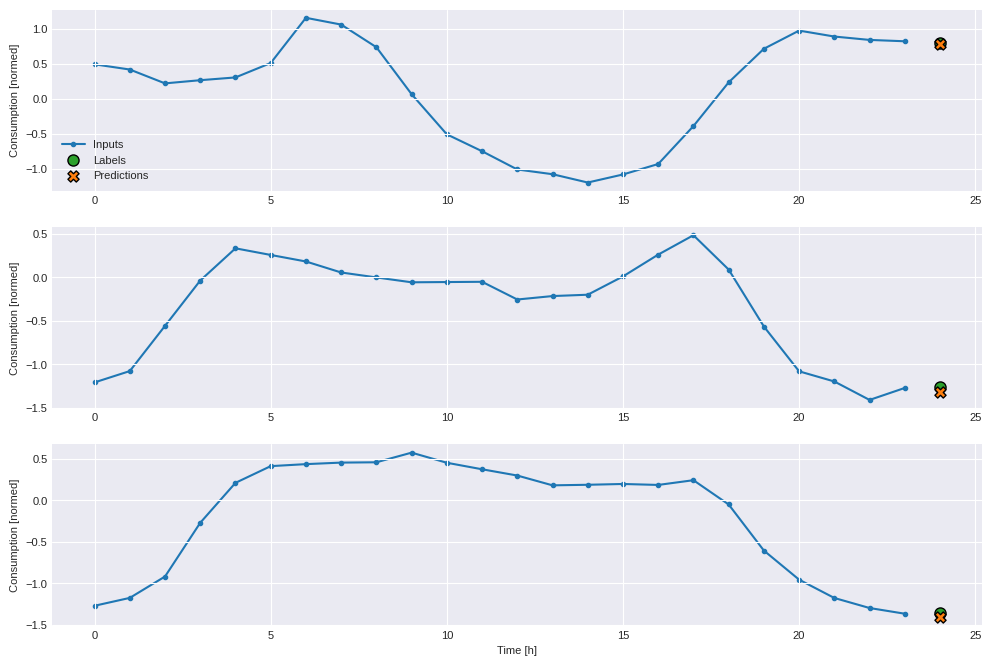

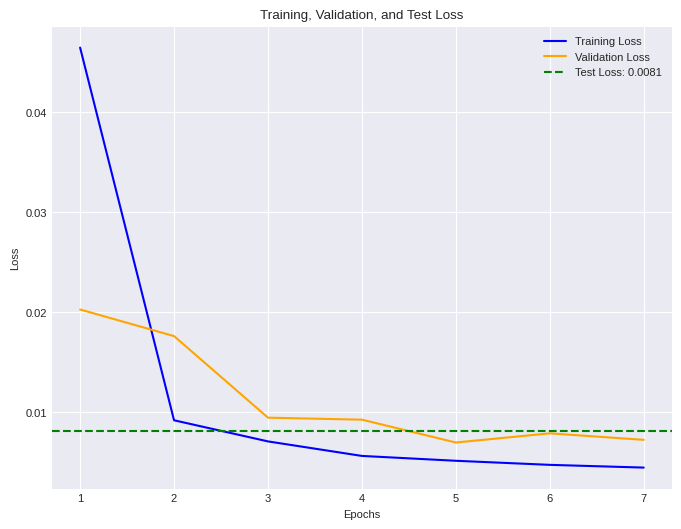

In [148]:
print("Conv window")
print('Input shape:', conv_window.example[0].shape)
print('Labels shape:', conv_window.example[1].shape)
print('Output shape:', wavenet_model(conv_window.example[0]).shape)

conv_window.plot(wavenet_model, plot_col='Consumption')
plot_history(wavenet_history, wavenet_model, conv_window)

In [155]:
plot_performance(val_performance, performance)

IndexError: invalid index to scalar variable.

# Multi-step prediction


### Recursive


In [ ]:
forecaster = ForecasterDirect(
    regressor=LGBMRegressor(random_state=15926, verbose=-1),
    steps=24,
    lags=24,
)

# Lags used as predictors
lags_grid = [24, (1, 2, 3, 23, 24, 25, 47, 48, 49)]

# Regressor hyperparameters search space


def search_space(trial):
    search_space = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 500, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 5, step=1),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 0.3, step=0.1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 0.3, step=0.1),
        'lags': trial.suggest_categorical('lags', lags_grid)
    }
    return search_space


# Folds training and validation
cv_search = TimeSeriesFold(
    steps=24,
    initial_train_size=len(train_df),
    refit=False,
)

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster=forecaster,
    y=pd.concat([train_df, val_df])['Consumption'],
    cv=cv_search,
    metric='mean_absolute_error',
    search_space=search_space,
    n_trials=10,  # Increase for more exhaustive search
    random_state=123,
    return_best=True,
    n_jobs='auto',
    verbose=False,
    show_progress=True
)

best_params = results_search.at[0, 'params']
best_params = best_params | {'random_state': 15926, 'verbose': -1}
best_lags = results_search.at[0, 'lags']

metric, predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=pd.concat([data_train, data_val, data_test])['Consumption'],
    cv=cv,
    metric='mean_absolute_error',
    n_jobs='auto',
    verbose=False,  # Change to True to see detailed information
    show_progress=True
)

display(metric)
print(predictions.head())

print(f"MAE: {metric}")

data_test['Consumption'][:24*7].plot()
predictions['pred'][:24*7].plot()

  0%|          | 0/10 [00:00<?, ?it/s]

MAE:    mean_absolute_error
0             0.203182


<Axes: xlabel='DateTime'>

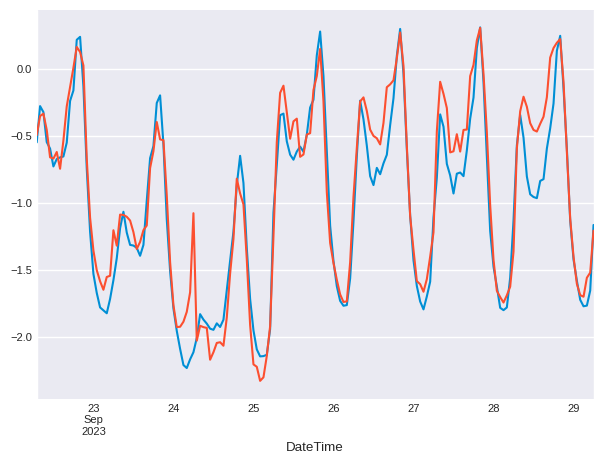

### Direct multi-step


In [ ]:
forecaster = ForecasterDirect(
    regressor=LGBMRegressor(**best_params),
    steps=24,
    lags=24,
)

# Backtesting model
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=pd.concat([train_df, val_df, test_df])['Consumption'],
    cv=cv,
    metric='mean_absolute_error',
    n_jobs='auto',
    verbose=False,
    show_progress=True
)

display(metric)
predictions.head()

  0%|          | 0/192 [00:00<?, ?it/s]

,mean_absolute_error
0,0.203182


,pred
2023-09-22 07:00:00,-0.494709
2023-09-22 08:00:00,-0.351762
2023-09-22 09:00:00,-0.334150
2023-09-22 10:00:00,-0.455022
2023-09-22 11:00:00,-0.659721


In [ ]:
predictions.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(4601, 1)

### Neural Networks


In [ ]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=['Consumption'])

multi_window.plot()
multi_window

NameError: name 'WindowGenerator' is not defined

In [ ]:
multi_val_performance = {}
multi_performance = {}

In [ ]:
for example_inputs, example_labels in multi_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 40)
Labels shape (batch, time, features): (32, 24, 1)


In [ ]:
for example_inputs, example_labels in seq2seq_train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 40)
Labels shape (batch, time, features): (32, 24, 24)


In [ ]:
type(seq2seq_train)

tensorflow.python.data.ops.batch_op._BatchDataset

In [ ]:
def compile_and_fit_custom(model, train, valid, patience=5):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(train, epochs=MAX_EPOCHS,
                        validation_data=valid,
                        callbacks=[early_stopping])
    return history


wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 40]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu",
        dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=24, kernel_size=1))

wavenet_history = compile_and_fit_custom(
    wavenet_model, seq2seq_train, seq2seq_valid, multi_window)

val_performance['Wavenet'] = wavenet_model.evaluate(
    multi_window.val, return_dict=True)
performance['Wavenet'] = wavenet_model.evaluate(
    multi_window.test, verbose=0, return_dict=True)

Epoch 1/50
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step - loss: 0.5688 - mean_absolute_error: 0.5947 - val_loss: 0.4710 - val_mean_absolute_error: 0.5292
Epoch 2/50
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - loss: 0.2419 - mean_absolute_error: 0.3855 - val_loss: 0.4259 - val_mean_absolute_error: 0.5012
Epoch 3/50
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - loss: 0.2198 - mean_absolute_error: 0.3656 - val_loss: 0.4077 - val_mean_absolute_error: 0.4904
Epoch 4/50
1003/1005 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2098 - mean_absolute_error: 0.3572

KeyboardInterrupt: 

Epoch 1/50
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.1263 - mean_absolute_error: 0.2367 - val_loss: 0.0590 - val_mean_absolute_error: 0.1776
Epoch 2/50
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0345 - mean_absolute_error: 0.1313 - val_loss: 0.0552 - val_mean_absolute_error: 0.1715
Epoch 3/50
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - loss: 0.0298 - mean_absolute_error: 0.1224 - val_loss: 0.0555 - val_mean_absolute_error: 0.1717
Epoch 4/50
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.0274 - mean_absolute_error: 0.1180 - val_loss: 0.0513 - val_mean_absolute_error: 0.1630
Epoch 5/50
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0250 - mean_absolute_error: 0.1130 - val_loss: 0.0585 - val_mean_absolute_error: 0.1738
Epoch 6/50
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.0237 - mean_absolute_error: 0.1102 - val_loss: 0.0544 - val_mean_absolute_error: 0.1673
Epoch 7/50
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0225 - mean_

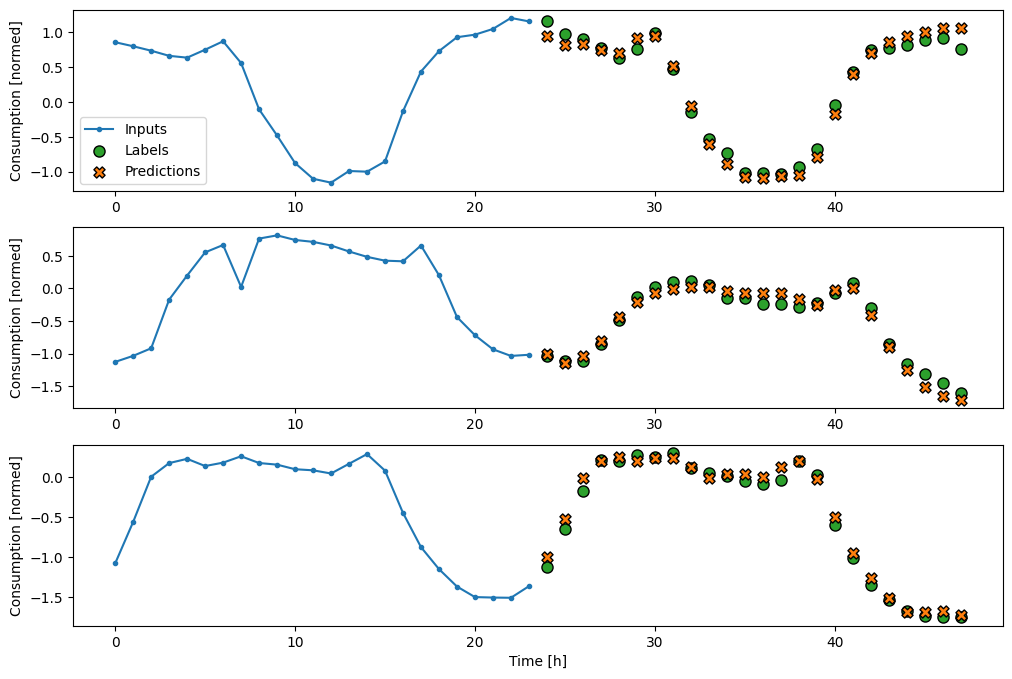

In [ ]:
CONV_WIDTH = 24
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_conv_model, multi_window)

multi_val_performance['Conv'] = multi_conv_model.evaluate(
    multi_window.val, return_dict=True)
multi_performance['Conv'] = multi_conv_model.evaluate(
    multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_conv_model)

Epoch 1/50
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.3486 - mean_absolute_error: 0.4430 - val_loss: 0.1041 - val_mean_absolute_error: 0.2442
Epoch 2/50
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 0.0499 - mean_absolute_error: 0.1643 - val_loss: 0.0935 - val_mean_absolute_error: 0.2287
Epoch 3/50
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 0.0378 - mean_absolute_error: 0.1393 - val_loss: 0.0930 - val_mean_absolute_error: 0.2256
Epoch 4/50
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 0.0325 - mean_absolute_error: 0.1274 - val_loss: 0.1004 - val_mean_absolute_error: 0.2309
Epoch 5/50
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 0.0292 - mean_absolute_error: 0.1203 - val_loss: 0.0963 - val_mean_absolute_error: 0.2241
Epoch 6/50
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 0.0273 - mean_absolute_error: 0.1160 - val_loss: 0.0955 - val_mean_absolute_error: 0.2220
Epoch 7/50
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 0.0258 - mea

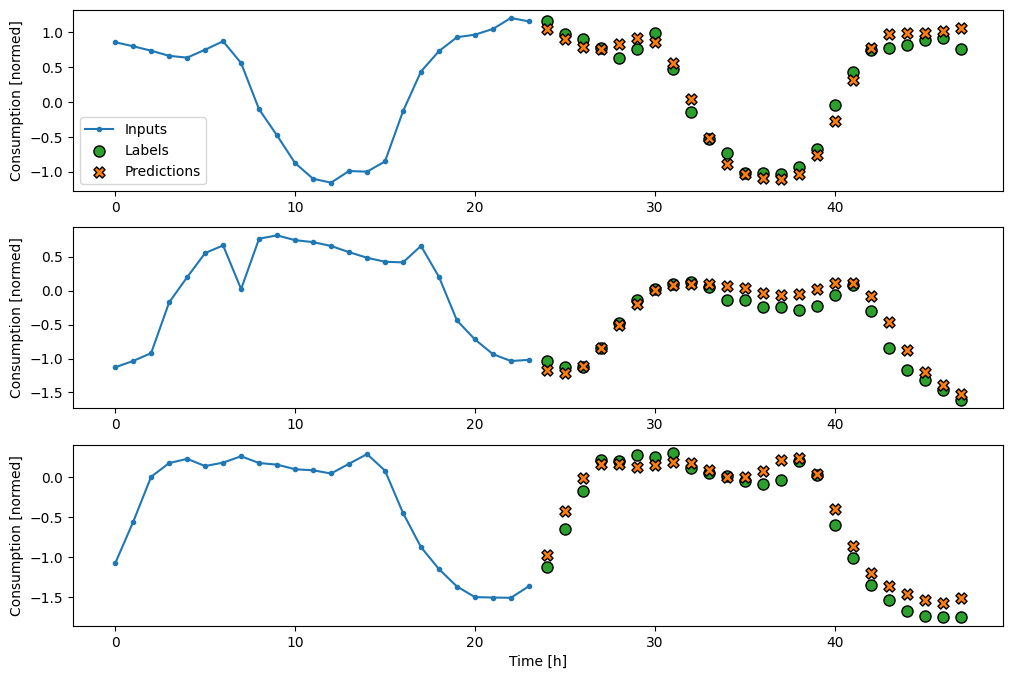

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(
    multi_window.val, return_dict=True)
multi_performance['LSTM'] = multi_lstm_model.evaluate(
    multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_lstm_model)

In [ ]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)


def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state


FeedBack.warmup = warmup


def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

    # Insert the first prediction.
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output.
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions


FeedBack.call = call

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

Epoch 1/50
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 37s 29ms/step - loss: 0.4086 - mean_absolute_error: 0.4923 - val_loss: 0.1694 - val_mean_absolute_error: 0.3278
Epoch 2/50
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 36s 24ms/step - loss: 0.0943 - mean_absolute_error: 0.2330 - val_loss: 0.1153 - val_mean_absolute_error: 0.2631
Epoch 3/50
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - loss: 0.0652 - mean_absolute_error: 0.1889 - val_loss: 0.0987 - val_mean_absolute_error: 0.2417
Epoch 4/50
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - loss: 0.0520 - mean_absolute_error: 0.1663 - val_loss: 0.0955 - val_mean_absolute_error: 0.2318
Epoch 5/50
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - loss: 0.0470 - mean_absolute_error: 0.1570 - val_loss: 0.0935 - val_mean_absolute_error: 0.2291
Epoch 6/50
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.0429 - mean_absolute_error: 0.1490 - val_loss: 0.0932 - val_mean_absolute_error: 0.2212
Epoch 7/50
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.0395 - mea

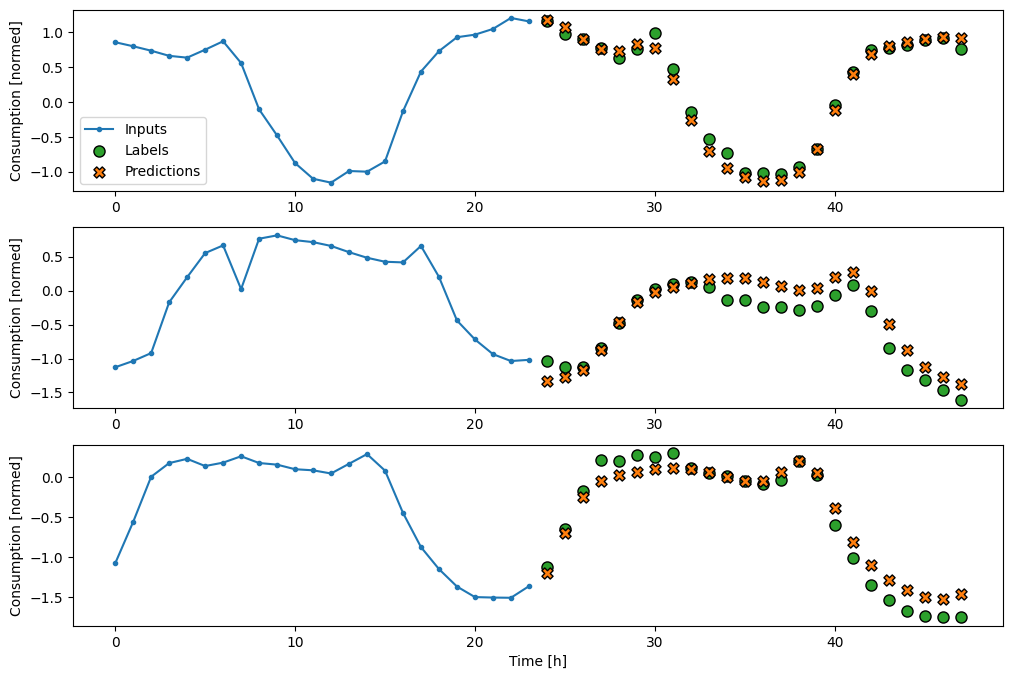

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

multi_val_performance['AR LSTM'] = feedback_model.evaluate(
    multi_window.val, return_dict=True)
multi_performance['AR LSTM'] = feedback_model.evaluate(
    multi_window.test, verbose=0, return_dict=True)
multi_window.plot(feedback_model)

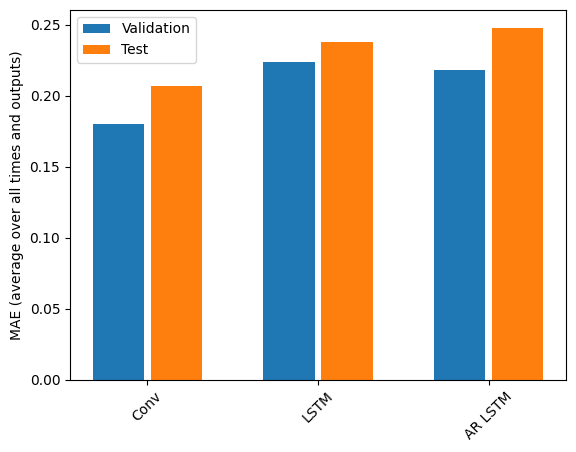

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in multi_val_performance.values()]
test_mae = [v[metric_name] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()